In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import date, timedelta

ToDo:
* przerzucić tutaj cały proces przeliczeń i wykresów z wycen excelowych
* 2 warianty:
    * zrobić dashboard, czyli wykresy w plotly i hostowanie jak w przypadku overview
    * zrzucać raporty do excela przez xlsx writera, wtedy wykresy raczej statyczne (chociaż może nie koniecznie)
* opcja 2 chyba byłaby bardziej dostosowana do cyklicznego raportowania, ale z drugiej strony, te raporty mają charakter inkrementalny, w sensie, co kwartał dane są takie same + kwartał, wiec bardziej to pasuje do monitorowania dashboardowego
* w dashboardzie możnaby zrobić taki fajny jednostronowy kompaktowy widok ze wszystkimi wykresikami i tabelkami upakowanymi w jedną stronę 16:9, żeby 

In [2]:
ticker_br = 'AMBRA'
ticker_yf = 'AMB.WA'

## Data scrapping and transformation

In [3]:
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

In [4]:
def table_cleaning(df):
    df = df.iloc[: , :-1]
    df.columns = df.columns.str.split('  ').str[0].str.replace('/', '', regex=True)

    for c in range(0, len(df.columns)):
        if 'k/k' in df.iloc[1,c]:
            df.iloc[:,c] = df.iloc[:,c].str.split('k/k').str[0]
        if 'r/r' in df.iloc[1,c]:
            df.iloc[:,c] = df.iloc[:,c].str.split('r/r').str[0]
        df.iloc[:,c] = df.iloc[:,c].astype(str).apply(lambda x: x.replace(' ', ''))
    
    df = df.T.reset_index()
    df = pd.concat([df, *[df.tail(1)]])
    df.iloc[-1, df.columns.get_loc('Data publikacji')] = date.today() - timedelta(days = 1)
    df.iloc[-1, df.columns.get_loc('index')] = 'Current'
    df['Data publikacji'] = pd.to_datetime(df['Data publikacji'])
    
    for c in df.columns[2:]:
        df[c] = df[c].astype(float)

    return df

In [5]:
url_rzis = 'https://www.biznesradar.pl/raporty-finansowe-rachunek-zyskow-i-strat/'+ticker_br+',Q'
url_bilans = 'https://www.biznesradar.pl/raporty-finansowe-bilans/'+ticker_br+',Q'
url_pp = 'https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/'+ticker_br+',Q'
url_c = 'https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/'+ticker_br+''

In [6]:
df_r_raw = pd.read_html(url_rzis, match='Data publikacji', index_col=0)[0]
df_b_raw = pd.read_html(url_bilans, match='Data publikacji', index_col=0)[0]
df_p_raw = pd.read_html(url_pp, match='Data publikacji', index_col=0)[0]

In [7]:
df_r = table_cleaning(df_r_raw)
df_b = table_cleaning(df_b_raw)
df_p = table_cleaning(df_p_raw)

In [8]:
prices = yf.download(ticker_yf, df_r['Data publikacji'].min(), date.today())['Close'].reset_index()
prices.columns = ['Data publikacji', 'Cena']

[*********************100%%**********************]  1 of 1 completed


In [9]:
df = df_r.merge(
    df_b, how='outer', left_on='Data publikacji', right_on='Data publikacji').merge(
        df_p, how='outer', left_on='Data publikacji', right_on='Data publikacji')
df = df.drop(columns=['index_y', 'index_x'])

In [10]:
df_c_raw = pd.read_html(url_c, match='Kurs', index_col=0)[0]

df_c = df_c_raw.iloc[: , :-1]
df_c.columns = df_c.columns.str.split('  ').str[0].str.replace('/', '', regex=True)
df_c = df_c.T
df_c = df_c['Liczba akcji'].reset_index()
df_c['Liczba akcji'] = df_c['Liczba akcji'].str.replace(' ', '', regex=True).astype(float)

In [11]:
df = df.merge(df_c, how='left', left_on='index', right_on='index')
df['Liczba akcji'] = df['Liczba akcji'].fillna(df['Liczba akcji'].mean())

In [12]:
df = df.merge(prices, how='left', left_on='Data publikacji', right_on='Data publikacji')

In [13]:
df.columns

Index(['Data publikacji', 'Przychody ze sprzedaży',
       'Techniczny koszt wytworzenia produkcji sprzedanej', 'Koszty sprzedaży',
       'Koszty ogólnego zarządu', 'Zysk ze sprzedaży',
       'Pozostałe przychody operacyjne', 'Pozostałe koszty operacyjne',
       'Zysk operacyjny (EBIT)', 'Przychody finansowe', 'Koszty finansowe',
       'Pozostałe przychody (koszty)', 'Zysk z działalności gospodarczej',
       'Wynik zdarzeń nadzwyczajnych', 'Zysk przed opodatkowaniem',
       'Zysk (strata) netto z działalności zaniechanej', 'Zysk netto',
       'Zysk netto akcjonariuszy jednostki dominującej', 'EBITDA',
       'Aktywa trwałe', 'Wartości niematerialne i prawne', 'Wartość firmy',
       'Rzeczowe składniki majątku trwałego',
       'Aktywa z tytułu prawa do użytkowania', 'Należności długoterminowe',
       'Inwestycje długoterminowe', 'Pozostałe aktywa trwałe',
       'Aktywa obrotowe', 'Zapasy', 'Należności krótkoterminowe',
       'Inwestycje krótkoterminowe',
       'Środki pieni

## Statistics

In [14]:
# Statystyki
stats = pd.DataFrame()
stats['index'] = df['index']
stats['Cena'] = df['Cena']
# Rynkowe
stats['Przychód na akcję'] = (df['Przychody ze sprzedaży'] * 1000) / df['Liczba akcji']
stats['Zysk netto na akcję (EPS)'] = (df['Zysk netto'] * 1000) / df['Liczba akcji']
stats['Wartość księgowa na akcję'] = (df['Kapitał własny akcjonariuszy jednostki dominującej'] * 1000) / df['Liczba akcji']
stats['Zobowiązania na akcję'] = ((df['Zobowiązania długoterminowe'] + df['Zobowiązania krótkoterminowe']) * 1000) / df['Liczba akcji']
stats['C/Z'] = stats['Cena'] / stats['Zysk netto na akcję (EPS)']
stats['C/WK'] = stats['Cena'] / stats['Wartość księgowa na akcję']
# Dywidend - dodać

# Przepływów
stats['Przepływy finansowe na akcję'] = (df['Przepływy pieniężne z działalności finansowej'] * 1000) / df['Liczba akcji']
stats['Przepływy inwestycyjne na akcję'] = (df['Przepływy pieniężne z działalności inwestycyjnej'] * 1000) / df['Liczba akcji']
stats['Przepływy operacyjne na akcję'] = (df['Przepływy pieniężne z działalności operacyjnej'] * 1000) / df['Liczba akcji']
# Rentowności
stats['ROE (zwrot z kapitału)'] = df['Zysk netto'] / df['Kapitał własny akcjonariuszy jednostki dominującej']
stats['ROA (zwrot z całości aktywów)'] = df['Zysk netto'] / df['Aktywa razem']
stats['ROS (zwrot ze sprzedaży)'] = df['Zysk netto'] / df['Przychody ze sprzedaży']
# Zadłużenia
stats['Debt Ratio (zadłużenie ogólne)'] = (df['Zobowiązania długoterminowe'] + df['Zobowiązania krótkoterminowe']) / df['Aktywa razem']
# Płynności
stats['Current Ratio (płynność bieżąca)'] = df['Aktywa obrotowe'] / df['Zobowiązania krótkoterminowe']
stats['Quick Ratio (płynność szybka)'] = (df['Aktywa obrotowe'] - df['Zapasy']) / df['Zobowiązania krótkoterminowe']
stats['Cash Ratio (płynność gotówkowa)'] = df['Środki pieniężne i inne aktywa pieniężne'] / df['Zobowiązania krótkoterminowe']

In [15]:
stats

,index,Cena,Przychód na akcję,Zysk netto na akcję (EPS),Wartość księgowa na akcję,Zobowiązania na akcję,C/Z,C/WK,Przepływy finansowe na akcję,Przepływy inwestycyjne na akcję,Przepływy operacyjne na akcję,ROE (zwrot z kapitału),ROA (zwrot z całości aktywów),ROS (zwrot ze sprzedaży),Debt Ratio (zadłużenie ogólne),Current Ratio (płynność bieżąca),Quick Ratio (płynność szybka),Cash Ratio (płynność gotówkowa)
0,2005Q1,10.100000,2.422258,0.055343,5.962436,6.628332,182.499723,1.693939,2.791367,-0.099537,-0.413066,0.009282,0.004225,0.022848,0.505969,1.822706,1.294442,0.469154
1,2005Q2,12.800000,5.934348,0.961056,6.562992,11.484829,13.318681,1.950330,0.587861,-0.675100,-0.446628,0.146436,0.050096,0.161948,0.598655,1.583624,1.253562,0.217550
2,2005Q3,15.200000,2.127971,-0.149484,6.471429,6.946105,-101.682851,2.348786,-1.340718,-0.003332,1.129067,-0.023099,-0.010266,-0.070247,0.477052,2.109946,1.329554,0.384066
3,2005Q4,14.000000,3.027614,0.164877,6.633608,8.057836,84.911698,2.110465,0.296628,-0.095887,-0.022335,0.024855,0.010216,0.054458,0.499287,1.657227,1.071345,0.309461
4,2006Q1,15.020000,2.435033,-0.145081,6.495470,8.769712,-103.528522,2.312381,0.534026,-0.479556,-0.385454,-0.022336,-0.008785,-0.059581,0.531046,1.351108,0.786377,0.222233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2022Q3,25.000000,6.300799,0.152023,15.269268,10.850393,164.448356,1.637276,-2.184384,-0.216887,2.384173,0.009956,0.005253,0.024128,0.374917,1.903259,0.843202,0.121997
71,2022Q4,29.400000,7.613033,0.467020,15.500397,12.315682,62.952372,1.896726,-0.102632,-0.335467,0.385454,0.030130,0.015248,0.061345,0.402100,1.802205,0.758444,0.099374
72,2023Q1,29.700001,7.865069,0.548387,15.980906,13.779581,54.158818,1.858468,1.227097,-0.667403,-0.267866,0.034315,0.016715,0.069724,0.419998,1.721318,0.725887,0.116545
73,2023Q2,31.500000,13.756175,1.678129,15.937703,18.339847,18.770905,1.976445,-0.362285,-0.344512,0.456665,0.105293,0.044960,0.121991,0.491356,1.529523,0.907096,0.067762


## Plots

<Axes: >

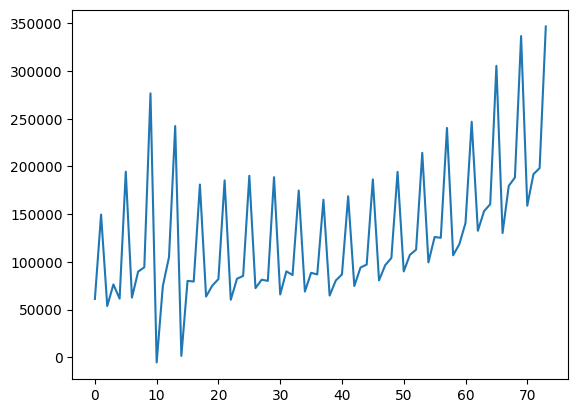

In [171]:
df_r['Przychody ze sprzedaży'].plot()

<Axes: >

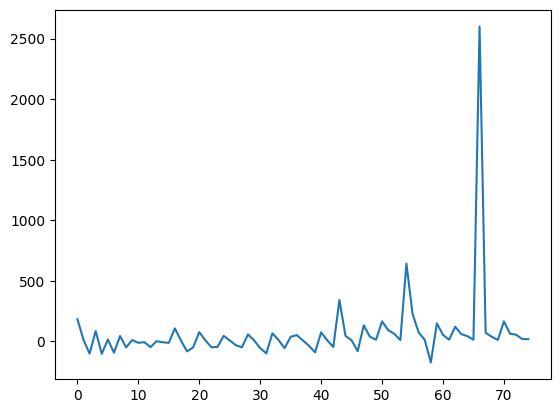

In [177]:
stats['C/Z'].plot()

In [156]:
stats['index'] = stats['index'].str[:4]

In [158]:
stats.groupby('index').sum()

,Przychód na akcję,Zysk netto na akcję (EPS)
index,,
2005,13.512191,1.031791
2006,16.192318,1.129861
2007,17.454128,-0.376607
2008,17.010237,0.323129
2009,15.825470,0.839342
2010,16.254921,0.920829
2011,17.023964,0.734767
2012,16.842861,0.942728
2013,16.590547,1.197264
